In [10]:
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder

# === 1. Charger les CSV filtrés ===
train_csv_path = "dataset_clean/train/filtered_train_sent_emo.csv"
test_csv_path = "dataset_clean/test/filtered_test_sent_emo.csv"

train_df = pd.read_csv(train_csv_path, sep=",")
test_df = pd.read_csv(test_csv_path, sep=",")

# === 2. Vérification des valeurs manquantes ===
print("Valeurs manquantes dans le train :")
print(train_df.isnull().sum())
print("\nValeurs manquantes dans le test :")
print(test_df.isnull().sum())

# === 3. Répartition des classes ===
print("\nRépartition des émotions dans le train :")
print(train_df["Emotion"].value_counts())
print("\nRépartition des émotions dans le test :")
print(test_df["Emotion"].value_counts())

# === 4. Encodage des labels ===
le_emotion = LabelEncoder()
train_df["Emotion"] = le_emotion.fit_transform(train_df["Emotion"])
test_df["Emotion"] = le_emotion.transform(test_df["Emotion"])

le_sentiment = LabelEncoder()
train_df["Sentiment"] = le_sentiment.fit_transform(train_df["Sentiment"])
test_df["Sentiment"] = le_sentiment.transform(test_df["Sentiment"])

# === 5. Ajout des chemins vers les fichiers audio ===
train_audio_folder = "dataset_clean/train/audios"
test_audio_folder = "dataset_clean/test/audios"

train_df["audio_path"] = train_df.apply(lambda row: f"{train_audio_folder}/dia{row['Dialogue_ID']}_utt{row['Utterance_ID']}.wav", axis=1)
test_df["audio_path"] = test_df.apply(lambda row: f"{test_audio_folder}/dia{row['Dialogue_ID']}_utt{row['Utterance_ID']}.wav", axis=1)

# === 6. Sauvegarder les CSV modifiés ===
os.makedirs("dataset_clean/train/meld_dl_autres_train", exist_ok=True)
os.makedirs("dataset_clean/test/meld_dl_autres_test", exist_ok=True)

train_df.to_csv("meld_dl_autres/train_processed.csv", index=False)
test_df.to_csv("meld_dl_autres/test_processed.csv", index=False)

print("\nPrétraitement terminé. CSV sauvegardés avec audio_path et labels encodés.")


Valeurs manquantes dans le train :
Emotion         0
Sentiment       0
Dialogue_ID     0
Utterance_ID    0
dtype: int64

Valeurs manquantes dans le test :
Emotion         0
Sentiment       0
Dialogue_ID     0
Utterance_ID    0
dtype: int64

Répartition des émotions dans le train :
Emotion
neutral     4709
joy         1743
surprise    1205
anger       1109
sadness      683
disgust      271
fear         268
Name: count, dtype: int64

Répartition des émotions dans le test :
Emotion
neutral     1256
joy          402
anger        345
surprise     281
sadness      208
disgust       68
fear          50
Name: count, dtype: int64

Prétraitement terminé. CSV sauvegardés avec audio_path et labels encodés.


### Script 1 : Prétraitement + Extraction MFCC + Sauvegarde dataset

In [11]:
import librosa
import numpy as np
import os
from tqdm import tqdm
import pandas as pd

def extract_mfcc_librosa(audio_path, sr=16000, n_mfcc=40):
    y, _ = librosa.load(audio_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfcc

def preprocess_and_save_librosa(df, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extraction MFCC librosa"):
        audio_path = row['audio_path']
        mfcc = extract_mfcc_librosa(audio_path)
        save_path = os.path.join(save_dir, f"{idx}.npy")
        np.save(save_path, mfcc)

# Exemple d’utilisation
if __name__ == "__main__":
    train_df = pd.read_csv("meld_dl_autres/train_processed.csv")
    preprocess_and_save_librosa(train_df, "meld_dl_autres/train/mfccs")


Extraction MFCC librosa:   0%|          | 0/9988 [00:00<?, ?it/s]C:\Users\boucceredj\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
Extraction MFCC librosa:   0%|          | 48/9988 [00:51<44:10,  3.75it/s]   C:\Users\boucceredj\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1366
  warnings.warn(
Extraction MFCC librosa:   7%|▋         | 728/9988 [03:23<24:15,  6.36it/s]  C:\Users\boucceredj\AppData\Roaming\Python\Python311\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(
Extraction MFCC librosa: 100%|██████████| 9988/9988 [40:02<00:00,  4.16it/s]  


In [12]:
import pandas as pd
import os
import numpy as np
import librosa
from tqdm import tqdm

def extract_mfcc_librosa(audio_path, sr=16000, n_mfcc=40):
    y, _ = librosa.load(audio_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfcc

def preprocess_and_save_librosa(df, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extraction MFCC test"):
        audio_path = row['audio_path']
        mfcc = extract_mfcc_librosa(audio_path)
        save_path = os.path.join(save_dir, f"{idx}.npy")
        np.save(save_path, mfcc)

# Lancer l'extraction
test_df = pd.read_csv("meld_dl_autres/test_processed.csv")
preprocess_and_save_librosa(test_df, "meld_dl_autres/test/mfccs")

Extraction MFCC test: 100%|██████████| 2610/2610 [11:52<00:00,  3.66it/s] 


### Script 2 : Chargement des MFCC sauvegardés + Entraînement


In [24]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm

def load_sliced_features(csv_path, mfcc_dir, slice_len=40):
    df = pd.read_csv(csv_path)
    features, labels = [], []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        path = os.path.join(mfcc_dir, f"{idx}.npy")
        if not os.path.exists(path): continue
        mfcc = np.load(path)
        if mfcc.shape[1] < slice_len:
            mfcc = np.pad(mfcc, ((0, 0), (0, slice_len - mfcc.shape[1])), mode='constant')
        else:
            mfcc = mfcc[:, :slice_len]
        features.append(mfcc.flatten())
        labels.append(row['Emotion'])
    return np.array(features), np.array(labels)

# Chargement
X_train, y_train = load_sliced_features("meld_dl_autres/train_processed.csv", "meld_dl_autres/train/mfccs")
X_test, y_test = load_sliced_features("meld_dl_autres/test_processed.csv", "meld_dl_autres/test/mfccs")

# Standardisation
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Dictionnaire de modèles rapides
models = {
    "LogisticRegression": LogisticRegression(max_iter=500, random_state=42),
    "SGDClassifier": SGDClassifier(max_iter=1000, tol=1e-3, random_state=42),
    "RidgeClassifier": RidgeClassifier(),
    "GaussianNB": GaussianNB(),
    "LinearSVC": LinearSVC(max_iter=1000, dual=False),
    "DecisionTree": DecisionTreeClassifier(max_depth=10),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=30, max_depth=10, random_state=42, n_jobs=-1),
    "KNN": KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
}

# Évaluation de chaque modèle
for name, model in models.items():
    print(f"\n🔹 Résultats pour : {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))


100%|██████████| 2610/2610 [00:03<00:00, 821.16it/s]



🔹 Résultats pour : LogisticRegression
              precision    recall  f1-score   support

           0       0.17      0.12      0.14       345
           1       0.02      0.03      0.02        68
           2       0.01      0.02      0.01        50
           3       0.14      0.12      0.13       402
           4       0.50      0.52      0.51      1256
           5       0.10      0.10      0.10       208
           6       0.12      0.10      0.10       281

    accuracy                           0.31      2610
   macro avg       0.15      0.14      0.15      2610
weighted avg       0.31      0.31      0.31      2610


🔹 Résultats pour : SGDClassifier


C:\Users\boucceredj\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.18      0.15      0.16       345
           1       0.03      0.01      0.02        68
           2       0.03      0.02      0.02        50
           3       0.16      0.17      0.16       402
           4       0.50      0.53      0.51      1256
           5       0.07      0.08      0.07       208
           6       0.13      0.12      0.13       281

    accuracy                           0.32      2610
   macro avg       0.16      0.15      0.15      2610
weighted avg       0.31      0.32      0.31      2610


🔹 Résultats pour : RidgeClassifier
              precision    recall  f1-score   support

           0       0.16      0.07      0.10       345
           1       0.00      0.00      0.00        68
           2       0.00      0.00      0.00        50
           3       0.15      0.13      0.14       402
           4       0.50      0.75      0.60      1256
           5       0.14      0.02      0.0

C:\Users\boucceredj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\boucceredj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\boucceredj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.25      0.00      0.01       345
           1       0.00      0.00      0.00        68
           2       0.00      0.00      0.00        50
           3       0.50      0.00      0.01       402
           4       0.48      1.00      0.65      1256
           5       0.00      0.00      0.00       208
           6       0.00      0.00      0.00       281

    accuracy                           0.48      2610
   macro avg       0.18      0.14      0.10      2610
weighted avg       0.34      0.48      0.32      2610


🔹 Résultats pour : KNN
              precision    recall  f1-score   support

           0       0.16      0.05      0.08       345
           1       0.00      0.00      0.00        68
           2       0.00      0.00      0.00        50
           3       0.15      0.07      0.10       402
           4       0.49      0.86      0.63      1256
           5       0.13      0.01      0.02       208


In [25]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Fonction pour charger les features MFCC découpées ou paddées à une taille fixe
def load_sliced_features(csv_path, mfcc_dir, slice_len=40):
    df = pd.read_csv(csv_path)
    features, labels = [], []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        path = os.path.join(mfcc_dir, f"{idx}.npy")
        if not os.path.exists(path):
            continue
        mfcc = np.load(path)
        if mfcc.shape[1] < slice_len:
            mfcc = np.pad(mfcc, ((0,0), (0, slice_len - mfcc.shape[1])), mode='constant')
        else:
            mfcc = mfcc[:, :slice_len]
        features.append(mfcc.flatten())
        labels.append(row['Emotion'])
    return np.array(features), np.array(labels)

# Chargement données
X_train, y_train = load_sliced_features("meld_dl_autres/train_processed.csv", "meld_dl_autres/train/mfccs")
X_test, y_test = load_sliced_features("meld_dl_autres/test_processed.csv", "meld_dl_autres/test/mfccs")

# Standardisation (important pour certains modèles)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Liste des modèles à tester
models = {
    "LogisticRegression": LogisticRegression(max_iter=200),
    "SGDClassifier": SGDClassifier(max_iter=1000), #redlist
    "RidgeClassifier": RidgeClassifier(),
    "GaussianNB": GaussianNB(),
    "LinearSVC": LinearSVC(max_iter=2000), #red
    "DecisionTree": DecisionTreeClassifier(),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=100, n_jobs=-1),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_jobs=-1)
}

# Entraînement et évaluation
for name, model in models.items():
    print(f"\n🔹 Résultats pour : {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, zero_division=0))


100%|██████████| 2610/2610 [00:02<00:00, 957.71it/s]



🔹 Résultats pour : LogisticRegression


C:\Users\boucceredj\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.18      0.14      0.16       345
           1       0.03      0.04      0.03        68
           2       0.01      0.02      0.01        50
           3       0.15      0.13      0.14       402
           4       0.51      0.52      0.52      1256
           5       0.09      0.09      0.09       208
           6       0.12      0.10      0.11       281

    accuracy                           0.31      2610
   macro avg       0.15      0.15      0.15      2610
weighted avg       0.31      0.31      0.31      2610


🔹 Résultats pour : SGDClassifier


C:\Users\boucceredj\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.13      0.10      0.12       345
           1       0.03      0.01      0.02        68
           2       0.03      0.02      0.02        50
           3       0.15      0.16      0.15       402
           4       0.50      0.50      0.50      1256
           5       0.08      0.09      0.08       208
           6       0.13      0.15      0.14       281

    accuracy                           0.30      2610
   macro avg       0.15      0.15      0.15      2610
weighted avg       0.30      0.30      0.30      2610


🔹 Résultats pour : RidgeClassifier
              precision    recall  f1-score   support

           0       0.16      0.07      0.10       345
           1       0.00      0.00      0.00        68
           2       0.00      0.00      0.00        50
           3       0.15      0.13      0.14       402
           4       0.50      0.75      0.60      1256
           5       0.14      0.02      0.0

C:\Users\boucceredj\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:24:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.26      0.04      0.07       345
           1       0.00      0.00      0.00        68
           2       0.00      0.00      0.00        50
           3       0.19      0.06      0.09       402
           4       0.49      0.93      0.64      1256
           5       0.25      0.00      0.01       208
           6       0.21      0.03      0.06       281

    accuracy                           0.47      2610
   macro avg       0.20      0.15      0.12      2610
weighted avg       0.34      0.47      0.34      2610



### Pour sentiment

In [26]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Fonction pour charger les features MFCC découpées ou paddées à une taille fixe
def load_sliced_features(csv_path, mfcc_dir, slice_len=40):
    df = pd.read_csv(csv_path)
    features, labels = [], []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        path = os.path.join(mfcc_dir, f"{idx}.npy")
        if not os.path.exists(path):
            continue
        mfcc = np.load(path)
        if mfcc.shape[1] < slice_len:
            mfcc = np.pad(mfcc, ((0,0), (0, slice_len - mfcc.shape[1])), mode='constant')
        else:
            mfcc = mfcc[:, :slice_len]
        features.append(mfcc.flatten())
        labels.append(row['Sentiment'])
    return np.array(features), np.array(labels)

# Chargement données
X_train, y_train = load_sliced_features("meld_dl_autres/train_processed.csv", "meld_dl_autres/train/mfccs")
X_test, y_test = load_sliced_features("meld_dl_autres/test_processed.csv", "meld_dl_autres/test/mfccs")

# Standardisation (important pour certains modèles)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Liste des modèles à tester
models = {
    "LogisticRegression": LogisticRegression(max_iter=200),
    "SGDClassifier": SGDClassifier(max_iter=1000), #redlist
    "RidgeClassifier": RidgeClassifier(),
    "GaussianNB": GaussianNB(),
    "LinearSVC": LinearSVC(max_iter=2000), #red
    "DecisionTree": DecisionTreeClassifier(),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=100, n_jobs=-1),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_jobs=-1)
}

# Entraînement et évaluation
for name, model in models.items():
    print(f"\n🔹 Résultats pour : {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, zero_division=0))


100%|██████████| 2610/2610 [02:22<00:00, 18.36it/s]



🔹 Résultats pour : LogisticRegression


C:\Users\boucceredj\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.34      0.29      0.31       833
           1       0.50      0.57      0.53      1256
           2       0.20      0.18      0.19       521

    accuracy                           0.40      2610
   macro avg       0.35      0.35      0.35      2610
weighted avg       0.39      0.40      0.39      2610


🔹 Résultats pour : SGDClassifier
              precision    recall  f1-score   support

           0       0.35      0.34      0.34       833
           1       0.50      0.52      0.51      1256
           2       0.19      0.18      0.19       521

    accuracy                           0.40      2610
   macro avg       0.35      0.35      0.35      2610
weighted avg       0.39      0.40      0.39      2610


🔹 Résultats pour : RidgeClassifier
              precision    recall  f1-score   support

           0       0.35      0.28      0.31       833
           1       0.50      0.62      0.56      1256
     

C:\Users\boucceredj\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:19:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.39      0.25      0.30       833
           1       0.52      0.78      0.62      1256
           2       0.24      0.08      0.12       521

    accuracy                           0.47      2610
   macro avg       0.38      0.37      0.35      2610
weighted avg       0.42      0.47      0.42      2610



Répartition des classes dans le train :
 Sentiment
0    2945
1    4709
2    2334
Name: count, dtype: int64
Répartition des classes dans le test :
 Sentiment
0     833
1    1256
2     521
Name: count, dtype: int64


C:\Users\boucceredj\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\boucceredj\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


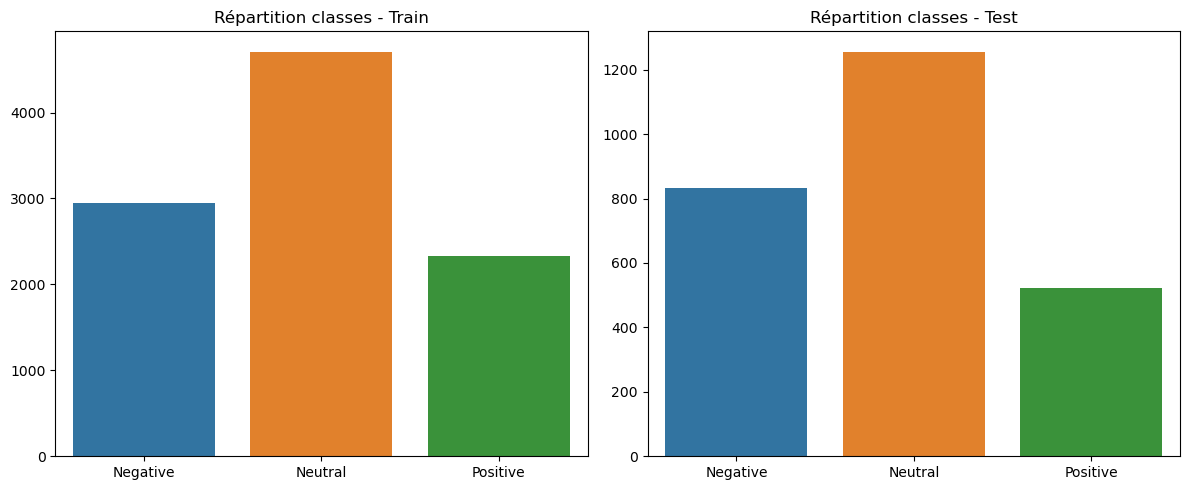

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Chargement des CSV (sans charger les MFCC)
train_df = pd.read_csv("meld_dl_autres/train_processed.csv")
test_df = pd.read_csv("meld_dl_autres/test_processed.csv")

# Comptage des classes dans la colonne 'Sentiment'
train_counts = train_df['Sentiment'].value_counts().sort_index()
test_counts = test_df['Sentiment'].value_counts().sort_index()

print("Répartition des classes dans le train :\n", train_counts)
print("Répartition des classes dans le test :\n", test_counts)

# Visualisation simple
labels = ['Negative', 'Neutral', 'Positive']

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.barplot(x=labels, y=train_counts.values, ax=axs[0])
axs[0].set_title("Répartition classes - Train")

sns.barplot(x=labels, y=test_counts.values, ax=axs[1])
axs[1].set_title("Répartition classes - Test")

plt.tight_layout()
plt.show()


In [5]:
!pip install imbalanced-learn

100%|██████████| 2610/2610 [00:03<00:00, 657.46it/s]
C:\Users\boucceredj\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


Distribution classes Train initiale :


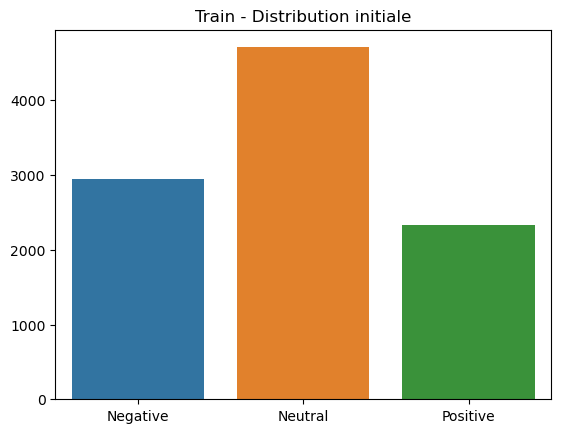

Distribution classes Test :


C:\Users\boucceredj\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


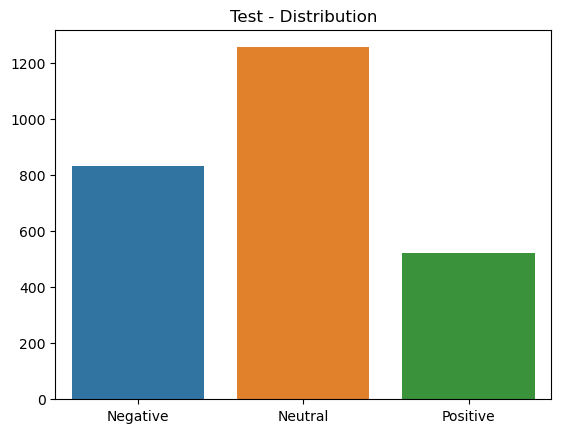


===> Baseline sans équilibrage
              precision    recall  f1-score   support

           0      0.346     0.291     0.316       833
           1      0.502     0.572     0.535      1256
           2      0.191     0.177     0.183       521

    accuracy                          0.403      2610
   macro avg      0.347     0.346     0.345      2610
weighted avg      0.390     0.403     0.395      2610


===> LogisticRegression avec class_weight='balanced'
              precision    recall  f1-score   support

           0      0.333     0.342     0.337       833
           1      0.512     0.396     0.446      1256
           2      0.194     0.292     0.233       521

    accuracy                          0.358      2610
   macro avg      0.346     0.343     0.339      2610
weighted avg      0.391     0.358     0.369      2610


===> RandomUnderSampler
Distribution après sous-échantillonnage :


C:\Users\boucceredj\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


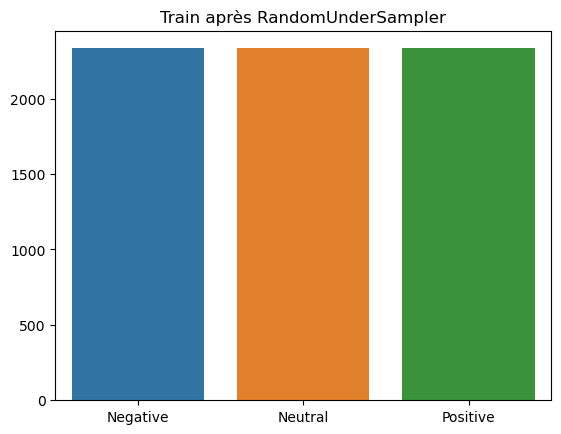

              precision    recall  f1-score   support

           0      0.326     0.341     0.333       833
           1      0.509     0.354     0.418      1256
           2      0.193     0.321     0.241       521

    accuracy                          0.343      2610
   macro avg      0.343     0.339     0.331      2610
weighted avg      0.387     0.343     0.356      2610


===> SMOTE
Distribution après SMOTE :


C:\Users\boucceredj\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


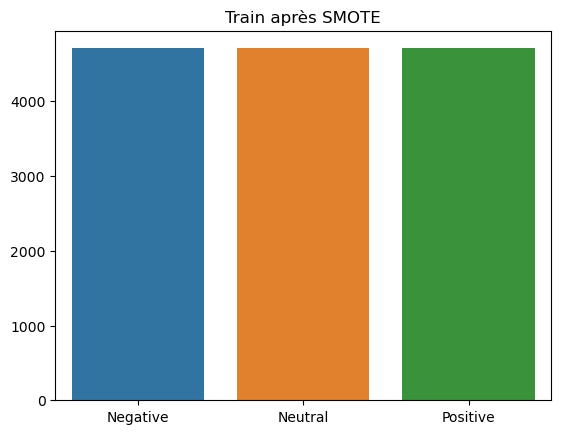

              precision    recall  f1-score   support

           0      0.332     0.346     0.339       833
           1      0.511     0.420     0.461      1256
           2      0.214     0.292     0.247       521

    accuracy                          0.370      2610
   macro avg      0.352     0.352     0.349      2610
weighted avg      0.395     0.370     0.379      2610



In [6]:
# LLogistic regression
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns

# --- Fonction chargement ---
def load_sliced_features(csv_path, mfcc_dir, slice_len=40):
    df = pd.read_csv(csv_path)
    features, labels = [], []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        path = os.path.join(mfcc_dir, f"{idx}.npy")
        if not os.path.exists(path):
            continue
        mfcc = np.load(path)
        if mfcc.shape[1] < slice_len:
            mfcc = np.pad(mfcc, ((0,0), (0, slice_len - mfcc.shape[1])), mode='constant')
        else:
            mfcc = mfcc[:, :slice_len]
        features.append(mfcc.flatten())
        labels.append(row['Sentiment'])
    return np.array(features), np.array(labels)

# --- Chargement données ---
X_train, y_train = load_sliced_features("meld_dl_autres/train_processed.csv", "meld_dl_autres/train/mfccs")
X_test, y_test = load_sliced_features("meld_dl_autres/test_processed.csv", "meld_dl_autres/test/mfccs")

# --- Affichage distribution initiale ---
def plot_distribution(y, title):
    counts = pd.Series(y).value_counts().sort_index()
    labels = ['Negative', 'Neutral', 'Positive']
    sns.barplot(x=labels, y=counts.values)
    plt.title(title)
    plt.show()

print("Distribution classes Train initiale :")
plot_distribution(y_train, "Train - Distribution initiale")

print("Distribution classes Test :")
plot_distribution(y_test, "Test - Distribution")

# --- Standardisation ---
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- Méthode 1 : baseline (pas d'équilibrage) ---
print("\n===> Baseline sans équilibrage")
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0, digits=3))

# --- Méthode 2 : class_weight balanced ---
print("\n===> LogisticRegression avec class_weight='balanced'")
model_balanced = LogisticRegression(max_iter=500, class_weight='balanced')
model_balanced.fit(X_train, y_train)
y_pred_balanced = model_balanced.predict(X_test)
print(classification_report(y_test, y_pred_balanced, zero_division=0, digits=3))

# --- Méthode 3 : RandomUnderSampler ---
print("\n===> RandomUnderSampler")
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)
print("Distribution après sous-échantillonnage :")
plot_distribution(y_rus, "Train après RandomUnderSampler")

model_rus = LogisticRegression(max_iter=500)
model_rus.fit(X_rus, y_rus)
y_pred_rus = model_rus.predict(X_test)
print(classification_report(y_test, y_pred_rus, zero_division=0, digits=3))

# --- Méthode 4 : SMOTE ---
print("\n===> SMOTE")
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)
print("Distribution après SMOTE :")
plot_distribution(y_smote, "Train après SMOTE")

model_smote = LogisticRegression(max_iter=500)
model_smote.fit(X_smote, y_smote)
y_pred_smote = model_smote.predict(X_test)
print(classification_report(y_test, y_pred_smote, zero_division=0, digits=3))


In [7]:
# extra trees c le meilleur ici
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier, RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Chargement des features MFCC
def load_sliced_features(csv_path, mfcc_dir, slice_len=40):
    df = pd.read_csv(csv_path)
    features, labels = [], []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        path = os.path.join(mfcc_dir, f"{idx}.npy")
        if not os.path.exists(path):
            continue
        mfcc = np.load(path)
        if mfcc.shape[1] < slice_len:
            mfcc = np.pad(mfcc, ((0,0), (0, slice_len - mfcc.shape[1])), mode='constant')
        else:
            mfcc = mfcc[:, :slice_len]
        features.append(mfcc.flatten())
        labels.append(row['Sentiment'])
    return np.array(features), np.array(labels)

# Chargement des données
X_train, y_train = load_sliced_features("meld_dl_autres/train_processed.csv", "meld_dl_autres/train/mfccs")
X_test, y_test = load_sliced_features("meld_dl_autres/test_processed.csv", "meld_dl_autres/test/mfccs")

# Standardisation
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Définition des modèles (sans LogisticRegression)
models = {
    "SGDClassifier": SGDClassifier(max_iter=1000, class_weight='balanced'),
    "RidgeClassifier": RidgeClassifier(class_weight='balanced'),
    "GaussianNB": GaussianNB(),  # pas de class_weight
    "LinearSVC": LinearSVC(max_iter=2000, class_weight='balanced'),
    "DecisionTree": DecisionTreeClassifier(class_weight='balanced'),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=100, n_jobs=-1, class_weight='balanced'),
    "KNN": KNeighborsClassifier(),  # pas de class_weight
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_jobs=-1, scale_pos_weight=1),
    "RandomForest": RandomForestClassifier(n_estimators=100, class_weight='balanced'),
    "MLPClassifier": MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300)
}

# Entraînement et évaluation
for name, model in models.items():
    print(f"\n🔹 Résultats pour : {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, zero_division=0))


100%|██████████| 2610/2610 [00:06<00:00, 388.86it/s]



🔹 Résultats pour : SGDClassifier
              precision    recall  f1-score   support

           0       0.34      0.34      0.34       833
           1       0.49      0.43      0.46      1256
           2       0.18      0.23      0.20       521

    accuracy                           0.36      2610
   macro avg       0.34      0.33      0.33      2610
weighted avg       0.38      0.36      0.37      2610


🔹 Résultats pour : RidgeClassifier
              precision    recall  f1-score   support

           0       0.34      0.36      0.35       833
           1       0.51      0.39      0.44      1256
           2       0.20      0.29      0.24       521

    accuracy                           0.36      2610
   macro avg       0.35      0.35      0.34      2610
weighted avg       0.39      0.36      0.37      2610


🔹 Résultats pour : GaussianNB
              precision    recall  f1-score   support

           0       0.40      0.42      0.41       833
           1       0.55     

C:\Users\boucceredj\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:58:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.39      0.25      0.30       833
           1       0.52      0.78      0.62      1256
           2       0.24      0.08      0.12       521

    accuracy                           0.47      2610
   macro avg       0.38      0.37      0.35      2610
weighted avg       0.42      0.47      0.42      2610


🔹 Résultats pour : RandomForest
              precision    recall  f1-score   support

           0       0.40      0.08      0.14       833
           1       0.49      0.95      0.65      1256
           2       0.30      0.01      0.01       521

    accuracy                           0.48      2610
   macro avg       0.40      0.35      0.26      2610
weighted avg       0.42      0.48      0.36      2610


🔹 Résultats pour : MLPClassifier
              precision    recall  f1-score   support

           0       0.35      0.30      0.32       833
           1       0.51      0.56      0.54      1256
        

### deep learning

In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Chargement des données (comme avant, mais on ne flatten pas)
def load_sliced_features_3d(csv_path, mfcc_dir, slice_len=40):
    df = pd.read_csv(csv_path)
    features, labels = [], []
    for idx, row in df.iterrows():
        path = os.path.join(mfcc_dir, f"{idx}.npy")
        if not os.path.exists(path):
            continue
        mfcc = np.load(path)
        if mfcc.shape[1] < slice_len:
            mfcc = np.pad(mfcc, ((0, 0), (0, slice_len - mfcc.shape[1])), mode='constant')
        else:
            mfcc = mfcc[:, :slice_len]
        features.append(mfcc.T)  # transpose to (slice_len, n_features)
        labels.append(row['Sentiment'])
    return np.array(features), np.array(labels)

X_train, y_train = load_sliced_features_3d("meld_dl_autres/train_processed.csv", "meld_dl_autres/train/mfccs")
X_test, y_test = load_sliced_features_3d("meld_dl_autres/test_processed.csv", "meld_dl_autres/test/mfccs")

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# One-hot encode
y_train_cat = to_categorical(y_train_enc)
y_test_cat = to_categorical(y_test_enc)

# Normalize MFCC features (per feature)
mean = np.mean(X_train, axis=(0,1), keepdims=True)
std = np.std(X_train, axis=(0,1), keepdims=True)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

# Modèle LSTM simple
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(32),
    BatchNormalization(),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entraînement
history = model.fit(X_train, y_train_cat, validation_split=0.2, epochs=30, batch_size=64)

# Évaluation
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_test_enc, y_pred, target_names=le.classes_.astype(str)))


C:\Users\boucceredj\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 28s 75ms/step - accuracy: 0.3423 - loss: 1.3913 - val_accuracy: 0.4640 - val_loss: 1.0623
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.4461 - loss: 1.0758 - val_accuracy: 0.4725 - val_loss: 1.0542
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.4739 - loss: 1.0443 - val_accuracy: 0.4760 - val_loss: 1.0564
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.4966 - loss: 1.0233 - val_accuracy: 0.4815 - val_loss: 1.0622
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.4980 - loss: 1.0080 - val_accuracy: 0.4705 - val_loss: 1.0667
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.5141 - loss: 0.9924 - val_accuracy: 0.4710 - val_loss: 1.0722
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.5349 - loss: 0.9691 - val_accuracy: 0.4710 - val_loss: 1.0670
Epoch 8/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.5380 - loss: 0.9556 - val_ac

In [13]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

def load_sliced_features_3d(csv_path, mfcc_dir, slice_len=40):
    df = pd.read_csv(csv_path)
    features, labels = [], []
    for idx, row in df.iterrows():
        path = os.path.join(mfcc_dir, f"{idx}.npy")
        if not os.path.exists(path):
            continue
        mfcc = np.load(path)
        if mfcc.shape[1] < slice_len:
            mfcc = np.pad(mfcc, ((0, 0), (0, slice_len - mfcc.shape[1])), mode='constant')
        else:
            mfcc = mfcc[:, :slice_len]
        features.append(mfcc.T)  # transpose pour (slice_len, n_features)
        labels.append(row['Sentiment'])
    return np.array(features), np.array(labels)

# Chargement des données
X_train, y_train = load_sliced_features_3d("meld_dl_autres/train_processed.csv", "meld_dl_autres/train/mfccs")
X_test, y_test = load_sliced_features_3d("meld_dl_autres/test_processed.csv", "meld_dl_autres/test/mfccs")

# Encodage des labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Normalisation sur train (mean, std)
mean = np.mean(X_train, axis=(0,1), keepdims=True)
std = np.std(X_train, axis=(0,1), keepdims=True)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

# Split train/val
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train_enc, test_size=0.2, random_state=42)

# Modèle CNN 1D
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_final.shape[1], X_train_final.shape[2])),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Entraînement avec affichage epochs
history = model.fit(X_train_final, y_train_final,
                    validation_data=(X_val, y_val),
                    epochs=20,
                    batch_size=32,
                    verbose=1)

# Évaluation sur test
loss, acc = model.evaluate(X_test, y_test_enc, verbose=0)
print(f"Test accuracy: {acc:.4f}")


C:\Users\boucceredj\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.4379 - loss: 1.1284 - val_accuracy: 0.4680 - val_loss: 1.0556
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4706 - loss: 1.0592 - val_accuracy: 0.4845 - val_loss: 1.0408
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.4817 - loss: 1.0431 - val_accuracy: 0.4915 - val_loss: 1.0358
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5019 - loss: 1.0211 - val_accuracy: 0.4915 - val_loss: 1.0393
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5029 - loss: 1.0113 - val_accuracy: 0.4940 - val_loss: 1.0384
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5084 - loss: 0.9914 - val_accuracy: 0.5040 - val_loss: 1.0366
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5380 - loss: 0.9619 - val_accuracy: 0.4925 - val_loss: 1.0416
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5458 - loss: 0.9338 - val_accuracy